In [155]:
import intake
import numpy as np
import xarray as xr 
import dask
import xesmf as xe
import time 
import os

from xmip.preprocessing import rename_cmip6
from xmip.preprocessing import correct_lon
from xmip.preprocessing import promote_empty_dims

In [3]:
url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

In [4]:
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [5]:
def get_catalog():
    """
    Returns
    1) (catalog)    pangeo-cmip6 catalog subsetted for monthly ocean potential temperature (thetao) 
    2) (list)       unique_models (name of models or "source_id")
    """

    query = dict(experiment_id=['historical'], table_id=['Omon'],
                variable_id=['thetao'], grid_label=['gn'])

    cat = col.search(**query)

    df = cat.df

    # source_id is the model name
    unique_models = sorted(df["source_id"].unique())

    # skip ICON-ESM because it doesn't have xy coords 
    unique_models.remove('ICON-ESM-LR')
    # skip MCM-UA-1-0 because it has no y index 
    unique_models.remove('MCM-UA-1-0') 

    return cat, unique_models

cat, unique_models = get_catalog()


In [135]:
def regrid(da, model_name):
    """
    Regrid data to 5x5 grid using xesmf. 

    Param:
        (xr.DataArray)  data to regrid

    Returns:
        (xr.DataArray)  regridded 
    """

    output_grid = xe.util.grid_global(5, 5)
    weight_file = f'/scratch/users/yucli/enso_data/grids/{model_name}_to_5x5_bilinear_weights.nc'

    if os.path.exists(weight_file):
        regridder = xe.Regridder(da, output_grid, 'bilinear', weights=weight_file, 
                                ignore_degenerate=True, reuse_weights=True, periodic=True)
    else:
        regridder = xe.Regridder(da, output_grid, 'bilinear', filename=weight_file, 
                                ignore_degenerate=True, reuse_weights=False, periodic=True)

    da_regridded = regridder(da).load()

    return da_regridded


In [171]:
models_to_download = unique_models[0]

def xmip_preprocessing_wrapper(ds):
    ds = ds.copy()
    ds = rename_cmip6(ds)
    ds = promote_empty_dims(ds)
    ds = correct_lon(ds)
    return ds

def load_data_as_dset(source_id):
    cat_subset = cat.search(source_id=source_id)

    z_kwargs = {'consolidated':True, 'decode_times':False}

    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        dset_dict = cat_subset_test.to_dataset_dict(zarr_kwargs=z_kwargs, preprocess=xmip_preprocessing_wrapper)
    
    dset_ids = list(dset_dict.keys())

    if len(dset_ids) == 1: 
        return dset_dict[dset_ids[0]]
    else:
        raise ValueError(f"Found multiple datasets for the given query:\n{dset_ids}")

def subset_data(ds): 
    """
    From thetao (potential temperature), subset the SST (defined as the topmost depth)
    and T300 (weighted-average of top 300 m). 

    Note that xarray does lazy evaluation so no computation is actually done when you 
    call this. 

    Param:
        (xr.Dataset)    dset containing thetao as a variable 

    Returns:
        (xr.DataArray)  sst
        (xr.DataArray)  t300 
    """
    
    # get sst field 
    sst = ds.thetao.isel(lev=0)
    
    # check the units for the depth variable 'lev'
    lev_units = "m"
    if max(test_ds.lev.values) > 1e5: 
        lev_units = "cm"

    # select top 300 m to calculate OHC
    if lev_units == "m":
        depth_slice = slice(0,300) 
    elif lev_units == "cm":
        depth_slice = slice(0,30000)

    thetao_300m = ds.thetao.sel(lev=depth_slice)

    # calculate how thick each grid cell is to take the weighted mean over depth
    lev_midpoints = np.append([0], (test_ds.lev[1:].values + test_ds.lev[:-1].values) / 2)
    lev_thickness = np.diff(lev_midpoints)
    lev_thickness = lev_thickness[0:len(thetao_300m.lev)] 
    
    lev_weights = xr.DataArray(
        data=lev_thickness,
        dims=["lev"],
        coords=dict(
            lev=thetao_300m.lev.values # the weights live at the original levs, not the midpts
        ),
    ) 
    
    t300 = thetao_300m.weighted(lev_weights).mean("lev")

    # clean up this singleton dimension
    if "dcpp_init_year" in sst.coords: 
        sst = sst.isel(dcpp_init_year=0)
        t300 = t300.isel(dcpp_init_year=0)

    return sst, t300 



In [172]:
test_ds = load_data_as_dset([models_to_download])


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [177]:
for member in test_ds.member_id.values:
    print(member)

r1i1p1f1
r2i1p1f1
r3i1p1f1


In [174]:
sst_test, t300_test = subset_data(test_ds)

In [136]:
sst_regridded = regrid(sst_test, unique_models[0])

done! (Time taken: 853.86 seconds)


In [51]:
# select a subset to test
test_ds_subset = test_ds.thetao.isel(time=0, lev=0)

target_grid = xe.util.grid_global(5, 5)
regridder = xe.Regridder(test_ds_subset, target_grid, "bilinear")
test_ds_regridded = regridder(test_ds_subset)


In [144]:


sst_regridded.to_dataset(name="sst").assign_attrs(source_id="ACCESS-CM2", regrid_method="bilinear")

<xarray.Dataset> Size: 62MB
Dimensions:         (time: 1980, member_id: 3, y: 36, x: 72)
Coordinates:
    lev             float64 8B 5.0
  * time            (time) int64 16kB 0 708 1416 ... 1444152 1444884 1445616
  * member_id       (member_id) object 24B 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
    dcpp_init_year  float64 8B nan
    lon             (y, x) float64 21kB -177.5 -172.5 -167.5 ... 172.5 177.5
    lat             (y, x) float64 21kB -87.5 -87.5 -87.5 ... 87.5 87.5 87.5
Dimensions without coordinates: y, x
Data variables:
    sst             (member_id, time, y, x) float32 62MB nan nan ... -1.706
Attributes:
    source_id:      ACCESS-CM2
    regrid_method:  bilinear

In [57]:
lat_1d = test_ds_regridded['lat'][:, 0]  # Assuming lat varies along the first axis
lon_1d = test_ds_regridded['lon'][0, :]  # Assuming lon varies along the second axis

# Create a new DataArray with updated coordinates
test_ds_regridded_1d = test_ds_regridded.assign_coords(
    lat=lat_1d,
    lon=lon_1d
).rename({'x': 'lon', 'y': 'lat'})
test_ds_regridded_1d = test_ds_regridded_1d.set_index(lat='lat', lon='lon')


/tmp/ipykernel_19905/3891379289.py:8: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ).rename({'x': 'lon', 'y': 'lat'})
/tmp/ipykernel_19905/3891379289.py:8: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ).rename({'x': 'lon', 'y': 'lat'})


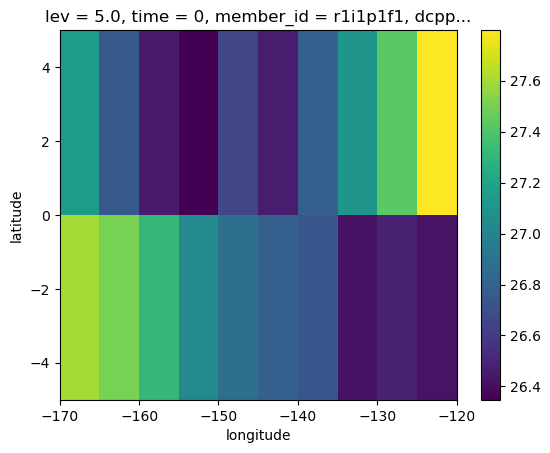

In [120]:
test_ds_regridded_1d.sel(lat=slice(-5, 5), lon=slice(-170,-120)).isel(member_id=0).plot()

In [50]:
test_ds_regridded = test_ds_regridded.set_coords(["lat", "lon"]) 
test_ds_regridded.sel(member_id='r1i1p1f1', lat=slice(0,20))

AttributeError: 'DataArray' object has no attribute 'set_coords'

# Preprocessed data

In [26]:
import xarray as xr
import numpy as np

preprocessed_ds = xr.open_dataset("/scratch/users/yucli/enso_data/CMIP_train.nc")

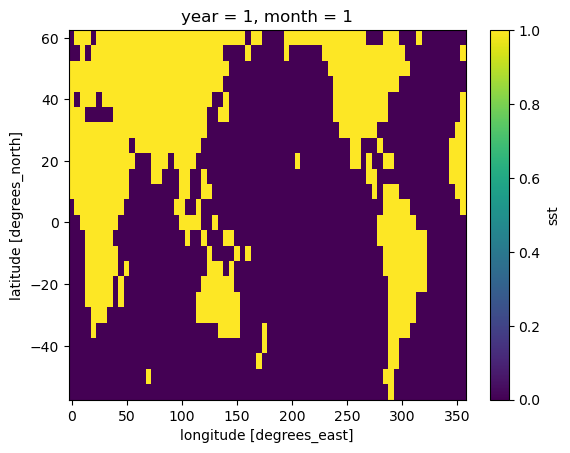

In [63]:
sea_mask = (preprocessed_ds.sst.isel(year=0,month=0) == 0)

sea_mask.plot()